![Pytorch](../../../pytorch_logo_2018.svg)

# Pytorch 高级篇（4）：图像标注（Image Captioning (CNN-RNN)）

>参考代码
>
>**yunjey的 [pytorch tutorial系列](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning#image-captioning)**
>
> 我的远程服务器没啥可视化界面可看，就把大神代码转到jupyter上看看效果

## 图像标注 学习资料

>**相关论文**
>
>[Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)

>**相关博客**
>
>[看图说话的AI小朋友——图像标注趣谈（上）](https://zhuanlan.zhihu.com/p/22408033)
>
>[「Show and Tell」——图像标注（Image Caption）任务技术综述](https://zhuanlan.zhihu.com/p/27771046)
>
>[CVPR2017 Image Caption有关论文总结](https://zhuanlan.zhihu.com/p/30893160)


## 图像标注 简介

图像标注也是牛逼轰轰的东西，今天就算搞不清楚，至少懂个大概也知足了。后面估计还是要涉足的。

图像标注就是将**输入的图像**转换为**自然语言描述**。编码器-解码器（encoder-decoder）架构被广泛用于这项任务。

图像编码器是一个卷积神经网络，这份代码里用的是**resnet-152**模型，它已经在 ILSVRC-2012-CLS 图像分类数据集上已经提前训练好了，

解码器使用的是长短期记忆（**LSTM**）网络。

图片来源：[Image Captioning](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning#image-captioning)

![Image Caption流程](../../../model.png)

图像标注的流程可以从RNN开始拓展，在机器翻译任务中，输入输出是单词序列，通过Encoder-Decoder结构。其中Encoder得到的是特征序列，因此，在图像标注中，将Encoder部分替换为图像输入+CNN提取特征（视觉特征），同样得到的特征序列供Decoder解码，即可。

当然，在上图的架构中，CNN使用的是resnet-152，Decoder部分使用了性能更好的LSTM。

## 训练和测试 过程介绍

### 训练阶段
对于编码器部分，预训练好的CNN模型会从给定的输入图像中提取特征向量。将特征向量进行线性转换，使之与LSTM网络的输入具有相同的维度。

对于解码器部分，源文本和目标文本已经预定义好。举例来说，如果图像的描述为"Giraffes standing next to each other"，那么源序列应该是一个集合，包含了 ['<start>', 'Giraffes', 'standing', 'next', 'to', 'each', 'other'] ，且目标序列应该是一个集合包含了['Giraffes', 'standing', 'next', 'to', 'each', 'other', '<end>']. 使用这些源序列、目标序列和特征向量，可以将LSTM解码器训练为一个基于特征向量的语言模型。

### 测试阶段

在测试阶段，编码器部分几乎和训练阶段相同。唯一的区别就是批归一化层（batch norm layer）使用移动平均和方差，而不是mini-batch统计，
这个直接通过调用`encoder.eval()`就实现了。

对于解码器部分，与训练阶段相比，明显的区别就是：在测试阶段，LSTM解码器不能看到图像的描述。为了解决这个问题，LSTM解码器将前一次生成的单词反馈作为下一次的输入。这个可以通过`for循环`实现。

## 安装COCO PythonAPI 和 下载数据集

**安装COCO API**
详情请咨询 [COCO](http://cocodataset.org/#home)
```
$ git clone https://github.com/pdollar/coco.git
$ cd coco/PythonAPI/
$ make
$ python setup.py build
$ python setup.py install
```

**数据集下载**
下载脚本，运行脚本(十几个G略慢)

```
$ wget https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/download.sh
$ chmod +x download.sh
$ ./download.sh
```


## 预处理

构建词汇表 和 图像大小缩放，适配数据集加载器Dataloader。

###  1. 构建词汇表

**refer**: [build_vocab.py](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/build_vocab.py)

In [2]:
# 包
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO

In [3]:
# 定义简单的词汇封装器
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [4]:
# 函数：构建词汇
def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [5]:
# 定义执行函数
def build_vocab_main(args):
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
    vocab_path = args.vocab_path
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

In [10]:
# 通过argparse传参数，并运行构建词汇库 
# 注意指定数据集相关文件的路径
parser = argparse.ArgumentParser()
parser.add_argument('--caption_path', type=str, 
                    default='/home/ubuntu/Datasets/coco/annotations/captions_train2014.json', 
                    help='path for train annotation file')
parser.add_argument('--vocab_path', type=str, default='/home/ubuntu/Datasets/coco/vocab.pkl', 
                    help='path for saving vocabulary wrapper')
parser.add_argument('--threshold', type=int, default=4, 
                    help='minimum word count threshold')
config = parser.parse_args(args=[])
build_vocab_main(config)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

[208000/414113] Tokenized the captions.
[209000/414113] Tokenized the captions.
[210000/414113] Tokenized the captions.
[211000/414113] Tokenized the captions.
[212000/414113] Tokenized the captions.
[213000/414113] Tokenized the captions.
[214000/414113] Tokenized the captions.
[215000/414113] Tokenized the captions.
[216000/414113] Tokenized the captions.
[217000/414113] Tokenized the captions.
[218000/414113] Tokenized the captions.
[219000/414113] Tokenized the captions.
[220000/414113] Tokenized the captions.
[221000/414113] Tokenized the captions.
[222000/414113] Tokenized the captions.
[223000/414113] Tokenized the captions.
[224000/414113] Tokenized the captions.
[225000/414113] Tokenized the captions.
[226000/414113] Tokenized the captions.
[227000/414113] Tokenized the captions.
[228000/414113] Tokenized the captions.
[229000/414113] Tokenized the captions.
[230000/414113] Tokenized the captions.
[231000/414113] Tokenized the captions.
[232000/414113] Tokenized the captions.


[414000/414113] Tokenized the captions.
Total vocabulary size: 9957
Saved the vocabulary wrapper to '/home/ubuntu/Datasets/coco/vocab.pkl'


### 2. 图像Resize操作

**refer**:[resize.py](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/resize.py)

In [11]:
# 包
import argparse
import os
from PIL import Image

In [12]:
# 定义函数 Resize图像
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

In [13]:
# 定义函数 Resize 图像序列 
def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))

In [15]:
# 定义主函数
def resize_main(args):
    image_dir = args.image_dir
    output_dir = args.output_dir
    image_size = [args.image_size, args.image_size]
    resize_images(image_dir, output_dir, image_size)

In [16]:
# 通过argparse传参数
# 注意指定数据集相关文件的路径
parser = argparse.ArgumentParser()
parser.add_argument('--image_dir', type=str, default='/home/ubuntu/Datasets/coco/train2014/',
                    help='directory for train images')
parser.add_argument('--output_dir', type=str, default='/home/ubuntu/Datasets/coco/resized2014/',
                    help='directory for saving resized images')
parser.add_argument('--image_size', type=int, default=256,
                    help='size for image after processing')
config = parser.parse_args(args=[])
resize_main(config)

[100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[1000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[1100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[1200/82783] Resize

[9300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[9400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[9500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[9600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[9700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[9800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[9900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[10000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[10100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[10200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[10300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[10400

[18400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[18500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[18600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[18700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[18800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[18900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[19000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[19100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[19200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[19300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[19400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.

[27500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[27600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[27700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[27800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[27900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[28000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[28100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[28200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[28300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[28400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[28500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.

[36600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[36700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[36800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[36900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[37000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[37100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[37200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[37300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[37400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[37500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[37600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.

[45700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[45800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[45900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[46700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.

[55000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[55900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[56000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.

[64100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[64900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[65000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[65100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.

[73200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[73300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[73400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[73500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[73600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[73700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[73800/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[73900/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[74000/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[74100/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[74200/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.

[82300/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[82400/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[82500/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[82600/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.
[82700/82783] Resized the images and saved into '/home/ubuntu/Datasets/coco/resized2014/'.


### 3.  数据集加载函数

**refer**: [data_loader.py](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/data_loader.py)

In [17]:
# 包
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
# from build_vocab import Vocabulary  # jupyter上已经定义好了函数
from pycocotools.coco import COCO

In [18]:
# 创建CocoDataset类，以适配Pytorch的数据加载类
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        # 将描述（字符串）转换为单词ID
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)

In [19]:
# 函数：从元组（image,caption）序列创建 mini-batch
# 之所以需要自己创建是因为默认不支持merging caption (including padding) i
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [20]:
# 获取数据加载器
def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

## 创建模型（编码器和解码器 Encoder and Decoder）

In [21]:
# 包
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

In [22]:
# 编码器 ResNet-152模型
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        # 替换最后一层全连接层
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        # 编码器用来实现提取特征，并不需要计算梯度
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [23]:
# 解码器 LSTM模型
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        # 超参数通过传参设置
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        # 前向传播是指将图像特征向量进行解码生成描述
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        # 使用贪心搜索从给定的图像特征生成描述
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## 训练模型

**refer**：[train.py](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/train.py)

In [24]:
# 包
import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
# from data_loader import get_loader 
# from build_vocab import Vocabulary
# from model import EncoderCNN, DecoderRNN
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

In [25]:
# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# 设置训练过程
def train_main(args):
    # 创建模型模型的文件夹
    if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
    
    # 配置transform: 图像预处理、归一化
    transform = transforms.Compose([ 
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    # 加载词汇封装文件
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    
    # 新建数据加载器
    data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                             transform, args.batch_size,
                             shuffle=True, num_workers=args.num_workers) 

    # 实例化编码器和解码器
    encoder = EncoderCNN(args.embed_size).to(device)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)
    
    # 社会损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=args.learning_rate)
    
    # 训练模型
    total_step = len(data_loader)
    for epoch in range(args.num_epochs):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # 设置mini-batch数据集
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # 前向传播-》反向传播-》优化
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            
            decoder.zero_grad() # 切记
            encoder.zero_grad() #切记
            loss.backward()
            
            optimizer.step()

            # 打印Log信息
            if i % args.log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 
                
            #  定期保存模型
            if (i+1) % args.save_step == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    args.model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    args.model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

In [30]:
# 设置参数
parser = argparse.ArgumentParser()

# 设置文件夹路径
parser.add_argument('--model_path', type=str, default='models/' , help='path for saving trained models')
parser.add_argument('--crop_size', type=int, default=224 , help='size for randomly cropping images')
parser.add_argument('--vocab_path', type=str, default='/home/ubuntu/Datasets/coco/vocab.pkl', help='path for vocabulary wrapper')
parser.add_argument('--image_dir', type=str, default='/home/ubuntu/Datasets/coco/resized2014', help='directory for resized images')
parser.add_argument('--caption_path', type=str, default='/home/ubuntu/Datasets/coco/annotations/captions_train2014.json', help='path for train annotation json file')

# 设置打印信息步长和保存步长
parser.add_argument('--log_step', type=int , default=10, help='step size for prining log info')
parser.add_argument('--save_step', type=int , default=1000, help='step size for saving trained models')

# 设置模型参数
parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')

# 设置超参数
parser.add_argument('--num_epochs', type=int, default=5)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--num_workers', type=int, default=2)
parser.add_argument('--learning_rate', type=float, default=0.001)

config = parser.parse_args(args=[])

print(config)

train_main(config)

Namespace(batch_size=128, caption_path='/home/ubuntu/Datasets/coco/annotations/captions_train2014.json', crop_size=224, embed_size=256, hidden_size=512, image_dir='/home/ubuntu/Datasets/coco/resized2014', learning_rate=0.001, log_step=10, model_path='models/', num_epochs=5, num_layers=1, num_workers=2, save_step=1000, vocab_path='/home/ubuntu/Datasets/coco/vocab.pkl')
loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
Epoch [0/5], Step [0/3236], Loss: 9.2119, Perplexity: 10015.3099
Epoch [0/5], Step [10/3236], Loss: 5.8402, Perplexity: 343.8538
Epoch [0/5], Step [20/3236], Loss: 5.4097, Perplexity: 223.5633
Epoch [0/5], Step [30/3236], Loss: 4.9667, Perplexity: 143.5454
Epoch [0/5], Step [40/3236], Loss: 4.7254, Perplexity: 112.7781
Epoch [0/5], Step [50/3236], Loss: 4.4457, Perplexity: 85.2637
Epoch [0/5], Step [60/3236], Loss: 4.3398, Perplexity: 76.6949
Epoch [0/5], Step [70/3236], Loss: 4.3727, Perplexity: 79.2537
Epoch [0/5], Step [80/3236], Loss: 4

Epoch [0/5], Step [1210/3236], Loss: 2.6750, Perplexity: 14.5128
Epoch [0/5], Step [1220/3236], Loss: 2.2793, Perplexity: 9.7696
Epoch [0/5], Step [1230/3236], Loss: 2.5319, Perplexity: 12.5776
Epoch [0/5], Step [1240/3236], Loss: 2.6751, Perplexity: 14.5141
Epoch [0/5], Step [1250/3236], Loss: 2.5773, Perplexity: 13.1619
Epoch [0/5], Step [1260/3236], Loss: 2.5018, Perplexity: 12.2045
Epoch [0/5], Step [1270/3236], Loss: 2.4475, Perplexity: 11.5596
Epoch [0/5], Step [1280/3236], Loss: 2.4882, Perplexity: 12.0396
Epoch [0/5], Step [1290/3236], Loss: 2.5053, Perplexity: 12.2467
Epoch [0/5], Step [1300/3236], Loss: 2.5290, Perplexity: 12.5408
Epoch [0/5], Step [1310/3236], Loss: 2.5671, Perplexity: 13.0285
Epoch [0/5], Step [1320/3236], Loss: 2.3916, Perplexity: 10.9311
Epoch [0/5], Step [1330/3236], Loss: 2.4744, Perplexity: 11.8740
Epoch [0/5], Step [1340/3236], Loss: 2.5514, Perplexity: 12.8246
Epoch [0/5], Step [1350/3236], Loss: 2.5571, Perplexity: 12.8977
Epoch [0/5], Step [1360/32

Epoch [0/5], Step [2480/3236], Loss: 2.3156, Perplexity: 10.1314
Epoch [0/5], Step [2490/3236], Loss: 2.3478, Perplexity: 10.4620
Epoch [0/5], Step [2500/3236], Loss: 2.3469, Perplexity: 10.4528
Epoch [0/5], Step [2510/3236], Loss: 2.2700, Perplexity: 9.6794
Epoch [0/5], Step [2520/3236], Loss: 2.4665, Perplexity: 11.7808
Epoch [0/5], Step [2530/3236], Loss: 2.3185, Perplexity: 10.1609
Epoch [0/5], Step [2540/3236], Loss: 2.4076, Perplexity: 11.1077
Epoch [0/5], Step [2550/3236], Loss: 2.2671, Perplexity: 9.6513
Epoch [0/5], Step [2560/3236], Loss: 2.4043, Perplexity: 11.0705
Epoch [0/5], Step [2570/3236], Loss: 2.2762, Perplexity: 9.7397
Epoch [0/5], Step [2580/3236], Loss: 2.2937, Perplexity: 9.9113
Epoch [0/5], Step [2590/3236], Loss: 2.4122, Perplexity: 11.1586
Epoch [0/5], Step [2600/3236], Loss: 2.5304, Perplexity: 12.5587
Epoch [0/5], Step [2610/3236], Loss: 2.2826, Perplexity: 9.8022
Epoch [0/5], Step [2620/3236], Loss: 2.2582, Perplexity: 9.5658
Epoch [0/5], Step [2630/3236], 

Epoch [1/5], Step [530/3236], Loss: 2.0610, Perplexity: 7.8535
Epoch [1/5], Step [540/3236], Loss: 2.1802, Perplexity: 8.8482
Epoch [1/5], Step [550/3236], Loss: 2.1914, Perplexity: 8.9475
Epoch [1/5], Step [560/3236], Loss: 2.0092, Perplexity: 7.4574
Epoch [1/5], Step [570/3236], Loss: 2.0228, Perplexity: 7.5596
Epoch [1/5], Step [580/3236], Loss: 2.1784, Perplexity: 8.8320
Epoch [1/5], Step [590/3236], Loss: 2.1748, Perplexity: 8.8005
Epoch [1/5], Step [600/3236], Loss: 2.1635, Perplexity: 8.7019
Epoch [1/5], Step [610/3236], Loss: 2.1459, Perplexity: 8.5499
Epoch [1/5], Step [620/3236], Loss: 2.2714, Perplexity: 9.6930
Epoch [1/5], Step [630/3236], Loss: 2.3485, Perplexity: 10.4701
Epoch [1/5], Step [640/3236], Loss: 2.0677, Perplexity: 7.9065
Epoch [1/5], Step [650/3236], Loss: 2.0486, Perplexity: 7.7572
Epoch [1/5], Step [660/3236], Loss: 2.0889, Perplexity: 8.0757
Epoch [1/5], Step [670/3236], Loss: 2.2245, Perplexity: 9.2491
Epoch [1/5], Step [680/3236], Loss: 2.1678, Perplexity

Epoch [1/5], Step [1820/3236], Loss: 2.0430, Perplexity: 7.7137
Epoch [1/5], Step [1830/3236], Loss: 2.0915, Perplexity: 8.0970
Epoch [1/5], Step [1840/3236], Loss: 2.1264, Perplexity: 8.3843
Epoch [1/5], Step [1850/3236], Loss: 2.2163, Perplexity: 9.1732
Epoch [1/5], Step [1860/3236], Loss: 1.9405, Perplexity: 6.9619
Epoch [1/5], Step [1870/3236], Loss: 2.0730, Perplexity: 7.9489
Epoch [1/5], Step [1880/3236], Loss: 2.3062, Perplexity: 10.0363
Epoch [1/5], Step [1890/3236], Loss: 2.2389, Perplexity: 9.3834
Epoch [1/5], Step [1900/3236], Loss: 2.1426, Perplexity: 8.5214
Epoch [1/5], Step [1910/3236], Loss: 2.1729, Perplexity: 8.7834
Epoch [1/5], Step [1920/3236], Loss: 2.1855, Perplexity: 8.8947
Epoch [1/5], Step [1930/3236], Loss: 2.2286, Perplexity: 9.2867
Epoch [1/5], Step [1940/3236], Loss: 2.2356, Perplexity: 9.3519
Epoch [1/5], Step [1950/3236], Loss: 2.0332, Perplexity: 7.6383
Epoch [1/5], Step [1960/3236], Loss: 2.1432, Perplexity: 8.5269
Epoch [1/5], Step [1970/3236], Loss: 2.

Epoch [1/5], Step [3100/3236], Loss: 2.0796, Perplexity: 8.0016
Epoch [1/5], Step [3110/3236], Loss: 2.0358, Perplexity: 7.6584
Epoch [1/5], Step [3120/3236], Loss: 2.1043, Perplexity: 8.2011
Epoch [1/5], Step [3130/3236], Loss: 2.0018, Perplexity: 7.4022
Epoch [1/5], Step [3140/3236], Loss: 2.0162, Perplexity: 7.5094
Epoch [1/5], Step [3150/3236], Loss: 1.9903, Perplexity: 7.3175
Epoch [1/5], Step [3160/3236], Loss: 1.9037, Perplexity: 6.7108
Epoch [1/5], Step [3170/3236], Loss: 2.1236, Perplexity: 8.3614
Epoch [1/5], Step [3180/3236], Loss: 2.0825, Perplexity: 8.0243
Epoch [1/5], Step [3190/3236], Loss: 2.1074, Perplexity: 8.2270
Epoch [1/5], Step [3200/3236], Loss: 2.1233, Perplexity: 8.3590
Epoch [1/5], Step [3210/3236], Loss: 2.0796, Perplexity: 8.0009
Epoch [1/5], Step [3220/3236], Loss: 2.0158, Perplexity: 7.5065
Epoch [1/5], Step [3230/3236], Loss: 2.1596, Perplexity: 8.6677
Epoch [2/5], Step [0/3236], Loss: 1.8626, Perplexity: 6.4406
Epoch [2/5], Step [10/3236], Loss: 1.9646, 

Epoch [2/5], Step [1160/3236], Loss: 2.1108, Perplexity: 8.2548
Epoch [2/5], Step [1170/3236], Loss: 2.0554, Perplexity: 7.8097
Epoch [2/5], Step [1180/3236], Loss: 2.0882, Perplexity: 8.0706
Epoch [2/5], Step [1190/3236], Loss: 2.0007, Perplexity: 7.3945
Epoch [2/5], Step [1200/3236], Loss: 2.0096, Perplexity: 7.4606
Epoch [2/5], Step [1210/3236], Loss: 2.1104, Perplexity: 8.2516
Epoch [2/5], Step [1220/3236], Loss: 1.9094, Perplexity: 6.7491
Epoch [2/5], Step [1230/3236], Loss: 2.0533, Perplexity: 7.7937
Epoch [2/5], Step [1240/3236], Loss: 1.9541, Perplexity: 7.0574
Epoch [2/5], Step [1250/3236], Loss: 2.0659, Perplexity: 7.8927
Epoch [2/5], Step [1260/3236], Loss: 2.0563, Perplexity: 7.8170
Epoch [2/5], Step [1270/3236], Loss: 2.0447, Perplexity: 7.7265
Epoch [2/5], Step [1280/3236], Loss: 1.9399, Perplexity: 6.9581
Epoch [2/5], Step [1290/3236], Loss: 2.0142, Perplexity: 7.4951
Epoch [2/5], Step [1300/3236], Loss: 1.9738, Perplexity: 7.1981
Epoch [2/5], Step [1310/3236], Loss: 2.0

Epoch [2/5], Step [2450/3236], Loss: 1.9607, Perplexity: 7.1042
Epoch [2/5], Step [2460/3236], Loss: 2.0373, Perplexity: 7.6698
Epoch [2/5], Step [2470/3236], Loss: 2.0690, Perplexity: 7.9171
Epoch [2/5], Step [2480/3236], Loss: 1.9629, Perplexity: 7.1197
Epoch [2/5], Step [2490/3236], Loss: 2.0564, Perplexity: 7.8175
Epoch [2/5], Step [2500/3236], Loss: 2.0366, Perplexity: 7.6646
Epoch [2/5], Step [2510/3236], Loss: 2.1587, Perplexity: 8.6602
Epoch [2/5], Step [2520/3236], Loss: 1.9148, Perplexity: 6.7855
Epoch [2/5], Step [2530/3236], Loss: 1.9321, Perplexity: 6.9037
Epoch [2/5], Step [2540/3236], Loss: 2.0570, Perplexity: 7.8224
Epoch [2/5], Step [2550/3236], Loss: 1.9713, Perplexity: 7.1798
Epoch [2/5], Step [2560/3236], Loss: 2.0508, Perplexity: 7.7740
Epoch [2/5], Step [2570/3236], Loss: 2.0467, Perplexity: 7.7422
Epoch [2/5], Step [2580/3236], Loss: 1.9932, Perplexity: 7.3390
Epoch [2/5], Step [2590/3236], Loss: 2.0902, Perplexity: 8.0861
Epoch [2/5], Step [2600/3236], Loss: 1.9

Epoch [3/5], Step [500/3236], Loss: 1.9948, Perplexity: 7.3507
Epoch [3/5], Step [510/3236], Loss: 1.9423, Perplexity: 6.9748
Epoch [3/5], Step [520/3236], Loss: 1.9877, Perplexity: 7.2985
Epoch [3/5], Step [530/3236], Loss: 1.9965, Perplexity: 7.3636
Epoch [3/5], Step [540/3236], Loss: 1.8849, Perplexity: 6.5859
Epoch [3/5], Step [550/3236], Loss: 2.0705, Perplexity: 7.9285
Epoch [3/5], Step [560/3236], Loss: 1.8286, Perplexity: 6.2249
Epoch [3/5], Step [570/3236], Loss: 1.9297, Perplexity: 6.8874
Epoch [3/5], Step [580/3236], Loss: 1.8790, Perplexity: 6.5466
Epoch [3/5], Step [590/3236], Loss: 1.9741, Perplexity: 7.1999
Epoch [3/5], Step [600/3236], Loss: 1.8416, Perplexity: 6.3068
Epoch [3/5], Step [610/3236], Loss: 1.9081, Perplexity: 6.7406
Epoch [3/5], Step [620/3236], Loss: 1.9293, Perplexity: 6.8844
Epoch [3/5], Step [630/3236], Loss: 1.8913, Perplexity: 6.6278
Epoch [3/5], Step [640/3236], Loss: 1.9079, Perplexity: 6.7387
Epoch [3/5], Step [650/3236], Loss: 1.9435, Perplexity:

Epoch [3/5], Step [1790/3236], Loss: 1.9718, Perplexity: 7.1835
Epoch [3/5], Step [1800/3236], Loss: 1.8654, Perplexity: 6.4588
Epoch [3/5], Step [1810/3236], Loss: 1.9619, Perplexity: 7.1128
Epoch [3/5], Step [1820/3236], Loss: 1.9903, Perplexity: 7.3180
Epoch [3/5], Step [1830/3236], Loss: 1.9100, Perplexity: 6.7533
Epoch [3/5], Step [1840/3236], Loss: 1.8460, Perplexity: 6.3346
Epoch [3/5], Step [1850/3236], Loss: 1.8752, Perplexity: 6.5223
Epoch [3/5], Step [1860/3236], Loss: 1.9972, Perplexity: 7.3684
Epoch [3/5], Step [1870/3236], Loss: 1.9507, Perplexity: 7.0333
Epoch [3/5], Step [1880/3236], Loss: 1.8862, Perplexity: 6.5942
Epoch [3/5], Step [1890/3236], Loss: 1.9262, Perplexity: 6.8632
Epoch [3/5], Step [1900/3236], Loss: 1.8114, Perplexity: 6.1190
Epoch [3/5], Step [1910/3236], Loss: 2.0261, Perplexity: 7.5841
Epoch [3/5], Step [1920/3236], Loss: 1.9264, Perplexity: 6.8645
Epoch [3/5], Step [1930/3236], Loss: 1.9975, Perplexity: 7.3709
Epoch [3/5], Step [1940/3236], Loss: 1.9

Epoch [3/5], Step [3080/3236], Loss: 1.9888, Perplexity: 7.3066
Epoch [3/5], Step [3090/3236], Loss: 1.9981, Perplexity: 7.3752
Epoch [3/5], Step [3100/3236], Loss: 1.9957, Perplexity: 7.3575
Epoch [3/5], Step [3110/3236], Loss: 1.8661, Perplexity: 6.4631
Epoch [3/5], Step [3120/3236], Loss: 1.9291, Perplexity: 6.8834
Epoch [3/5], Step [3130/3236], Loss: 1.9012, Perplexity: 6.6937
Epoch [3/5], Step [3140/3236], Loss: 1.9410, Perplexity: 6.9660
Epoch [3/5], Step [3150/3236], Loss: 1.9197, Perplexity: 6.8188
Epoch [3/5], Step [3160/3236], Loss: 1.9030, Perplexity: 6.7060
Epoch [3/5], Step [3170/3236], Loss: 1.8874, Perplexity: 6.6021
Epoch [3/5], Step [3180/3236], Loss: 1.8579, Perplexity: 6.4103
Epoch [3/5], Step [3190/3236], Loss: 1.9672, Perplexity: 7.1506
Epoch [3/5], Step [3200/3236], Loss: 1.9309, Perplexity: 6.8960
Epoch [3/5], Step [3210/3236], Loss: 1.9535, Perplexity: 7.0534
Epoch [3/5], Step [3220/3236], Loss: 1.9123, Perplexity: 6.7688
Epoch [3/5], Step [3230/3236], Loss: 1.9

Epoch [4/5], Step [1140/3236], Loss: 2.0115, Perplexity: 7.4746
Epoch [4/5], Step [1150/3236], Loss: 1.9422, Perplexity: 6.9744
Epoch [4/5], Step [1160/3236], Loss: 1.7261, Perplexity: 5.6184
Epoch [4/5], Step [1170/3236], Loss: 1.8650, Perplexity: 6.4557
Epoch [4/5], Step [1180/3236], Loss: 1.9080, Perplexity: 6.7394
Epoch [4/5], Step [1190/3236], Loss: 1.8397, Perplexity: 6.2949
Epoch [4/5], Step [1200/3236], Loss: 1.8200, Perplexity: 6.1719
Epoch [4/5], Step [1210/3236], Loss: 1.8063, Perplexity: 6.0878
Epoch [4/5], Step [1220/3236], Loss: 1.8513, Perplexity: 6.3681
Epoch [4/5], Step [1230/3236], Loss: 1.7907, Perplexity: 5.9936
Epoch [4/5], Step [1240/3236], Loss: 1.8706, Perplexity: 6.4925
Epoch [4/5], Step [1250/3236], Loss: 1.8341, Perplexity: 6.2597
Epoch [4/5], Step [1260/3236], Loss: 1.9036, Perplexity: 6.7102
Epoch [4/5], Step [1270/3236], Loss: 1.7577, Perplexity: 5.7993
Epoch [4/5], Step [1280/3236], Loss: 1.9033, Perplexity: 6.7081
Epoch [4/5], Step [1290/3236], Loss: 1.7

Epoch [4/5], Step [2430/3236], Loss: 1.7658, Perplexity: 5.8465
Epoch [4/5], Step [2440/3236], Loss: 1.8826, Perplexity: 6.5707
Epoch [4/5], Step [2450/3236], Loss: 1.9450, Perplexity: 6.9938
Epoch [4/5], Step [2460/3236], Loss: 1.9911, Perplexity: 7.3238
Epoch [4/5], Step [2470/3236], Loss: 1.7984, Perplexity: 6.0397
Epoch [4/5], Step [2480/3236], Loss: 1.8681, Perplexity: 6.4757
Epoch [4/5], Step [2490/3236], Loss: 1.9291, Perplexity: 6.8834
Epoch [4/5], Step [2500/3236], Loss: 1.9409, Perplexity: 6.9650
Epoch [4/5], Step [2510/3236], Loss: 1.8964, Perplexity: 6.6619
Epoch [4/5], Step [2520/3236], Loss: 1.9156, Perplexity: 6.7908
Epoch [4/5], Step [2530/3236], Loss: 1.7589, Perplexity: 5.8059
Epoch [4/5], Step [2540/3236], Loss: 1.8454, Perplexity: 6.3308
Epoch [4/5], Step [2550/3236], Loss: 1.9651, Perplexity: 7.1353
Epoch [4/5], Step [2560/3236], Loss: 1.8642, Perplexity: 6.4505
Epoch [4/5], Step [2570/3236], Loss: 1.9709, Perplexity: 7.1769
Epoch [4/5], Step [2580/3236], Loss: 1.8

## 模型测试

**refer**: [sample.py](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/sample.py)

In [31]:
# 包
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
# from build_vocab import Vocabulary
# from model import EncoderCNN, DecoderRNN
from PIL import Image

In [32]:
# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# 定义函数 加载图像
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [34]:
# 定义测试函数
def test(args):
    # 图像预处理模块
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # 加载词汇表封装
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # 建立两个模型
    encoder = EncoderCNN(args.embed_size).eval()  # 切换成评估模式 (即批归一化使用移动 均值/方差)
    decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # 加载训练好的模型的参数
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # 准备一幅图像
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # 从图像生成描述
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # 将词ID转换为单词
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # 打印图像和描述
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))

<start> a soccer player kicking a ball on a field . <end>


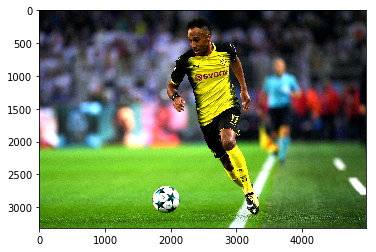

In [45]:
# 设置参数进行测试
parser = argparse.ArgumentParser()
parser.add_argument('--image', type=str, default='png/football2.jpg', help='input image for generating caption')
parser.add_argument('--encoder_path', type=str, default='models/encoder-5-3000.ckpt', help='path for trained encoder')
parser.add_argument('--decoder_path', type=str, default='models/decoder-5-3000.ckpt', help='path for trained decoder')
parser.add_argument('--vocab_path', type=str, default='/home/ubuntu/Datasets/coco/vocab.pkl', help='path for vocabulary wrapper')

# Model parameters (should be same as paramters in train.py)
parser.add_argument('--embed_size', type=int , default=256, help='dimension of word embedding vectors')
parser.add_argument('--hidden_size', type=int , default=512, help='dimension of lstm hidden states')
parser.add_argument('--num_layers', type=int , default=1, help='number of layers in lstm')
config = parser.parse_args(args=[])
test(config)